In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### understand the data

In [4]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

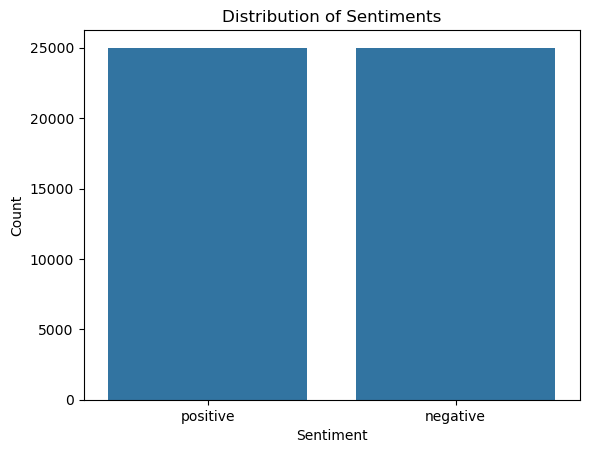

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vertical bar plot
sns.countplot(x=data['sentiment'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [6]:
data["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
# Random positive review
print(data[data['sentiment']=='positive']['review'].sample(1).values[0])

# Random negative review
print(data[data['sentiment']=='negative']['review'].sample(1).values[0])


When I started to watch this movie on VH-1 I cringed. The MTV movies were all bad so I wasnt expecting much. But this movie was really good. I liked it a lot. And it even had a twist at the end. See this movie because it shows that Made For TV movies that are good exist.
Zombie Review #3<br /><br />**Spoilers**<br /><br />Few films are actually "so bad they're good", and Zombi 3 is not just bad, it's wretchedly, unforgivably bad in so many ways that a whole new language may be needed just to describe them all<br /><br />More than that, it's a film credited to Lucio Fulci that even by his standards has absolutely no coherency, sense or reason. However we can't blame Fulci as it wasn't really directed by him but by Bruno Mattei, who doesn't even have Fulci's sense of style to help carry the film. Mattei seems to have brought little to the film but staggering ineptitude.<br /><br />So, I'm ashamed to say how much I enjoyed every worthless minute of Zombi 3. It has no redeeming features - 

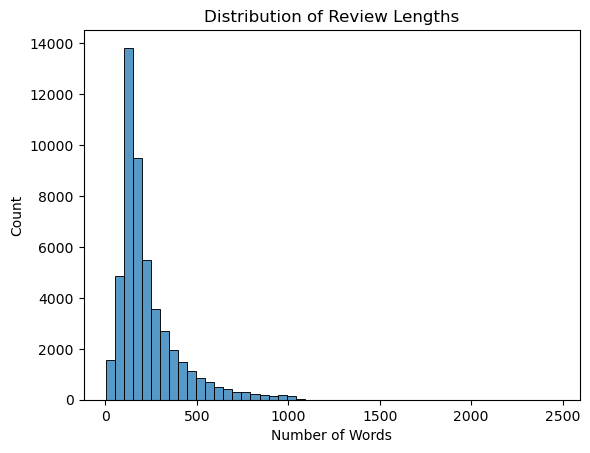

In [8]:
data['review_length'] = data['review'].apply(lambda x: len(x.split()))
sns.histplot(data['review_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.show()


### text preprocessing

In [9]:
# Convert reviews to lowercase
data['review'] = data['review'].str.lower()

# Check the result
data[['review']].head()


,review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production. <br /><br />the...
2,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is..."


In [10]:
import re

# Remove HTML tags
data['review'] = data['review'].apply(lambda x: re.sub(r'<.*?>', '', x))

# Check the result
data[['review']].head()


,review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is..."


In [11]:
# Remove non-alphabetic characters (keep only letters and spaces)
data['review'] = data['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Check the result
data[['review']].head()


,review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production the filming tech...
2,i thought this was a wonderful way to spend ti...
3,basically theres a family where a little boy j...
4,petter matteis love in the time of money is a ...


In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Remove stopwords
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Check the result
data[['review']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shanuja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review
0,one reviewers mentioned watching oz episode yo...
1,wonderful little production filming technique ...
2,thought wonderful way spend time hot summer we...
3,basically theres family little boy jake thinks...
4,petter matteis love time money visually stunni...


In [13]:
data.head()

,review,sentiment,review_length
0,one reviewers mentioned watching oz episode yo...,positive,307
1,wonderful little production filming technique ...,positive,162
2,thought wonderful way spend time hot summer we...,positive,166
3,basically theres family little boy jake thinks...,negative,138
4,petter matteis love time money visually stunni...,positive,230


### 4. Feature Extraction

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(data['review']).toarray()

print("TF-IDF Shape:", X_tfidf.shape)


TF-IDF Shape: (50000, 5000)


In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode sentiment column
le = LabelEncoder()
y = le.fit_transform(data['sentiment'])  # 1 = positive, 0 = negative

print("Classes:", le.classes_)
print("Encoded Labels:", y[:5])


Classes: ['negative' 'positive']
Encoded Labels: [1 1 1 0 1]


### model train and evaluation

In [16]:
from sklearn.model_selection import train_test_split

# Use TF-IDF features (recommended)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)

# Predict
y_pred_lr = log_reg.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.8877
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



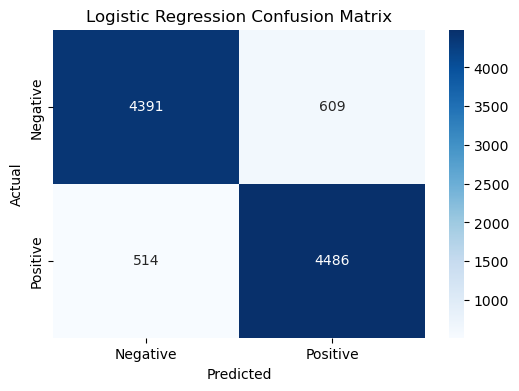

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [19]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict
y_pred_nb = nb.predict(X_test)

# Evaluate
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8545
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5000
           1       0.85      0.86      0.86      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [20]:
import joblib
joblib.dump(log_reg, 'logistic_model.pkl')

['logistic_model.pkl']

In [21]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [22]:
joblib.dump(nb, "naive_bayes_model.pkl")

['naive_bayes_model.pkl']

In [23]:
log_reg = joblib.load('logistic_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

sample = ["ohhhh"]
X_sample = tfidf_vectorizer.transform(sample)
prediction = log_reg.predict(X_sample)

print("Predicted Sentiment:", prediction[0])

Predicted Sentiment: 0
